In [1]:
import matplotlib.pyplot as plt
import pandas
import seaborn as sns
import xarray
import numpy as np
from pyeosim.datasets import DATA_PATHS
from pyeosim.sensor import TeledyneCMOS, TCMOS_test
from pyeosim.postprocess import CmosReflectance
from pyeosim.atmosphere import Test6S
from pyeosim.plot import rgb
from pyeosim.measure import NDVI
from sklearn import linear_model

In [2]:
# load and preprocess imagery
fpath = DATA_PATHS['TEST_HSI_LARGE']
im = xarray.open_dataset(fpath).Reflectance
im = im.swap_dims({'band':'wavelength'})
im_ref = im.sel(wavelength=slice(400,898)).astype(float)/10000

In [3]:
atmos = Test6S()
# generate Top of Atmosphere images
TOA = atmos.transform(im_ref).compute()
TOA_ref = atmos.transform(xarray.ones_like(im_ref))

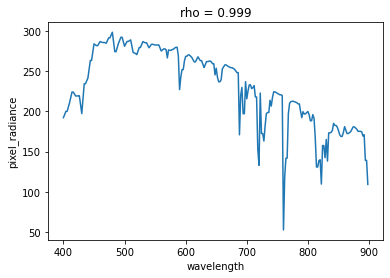

In [10]:
(atmos.LUT.sel(rho=1, method='nearest')*1000).plot()

In [ ]:
atmos.LUT.isel(rho=1).plot()

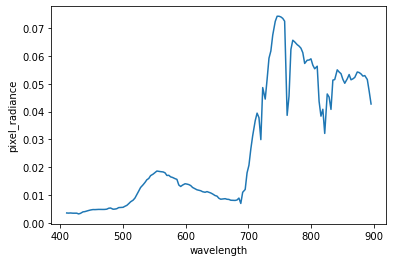

In [148]:
TOA_bands = cmos.spectral_response.transform(TOA)
TOA_ndvi = (TOA_bands.isel(band=9) - TOA_bands.isel(band=5))/(TOA_bands.isel(band=9) + TOA_bands.isel(band=5))
TOA_veg_median = TOA.where(TOA_ndvi > 0).median(['x','y'])
TOA_veg_median.plot()

In [149]:
# Use the vegetation median signal to generate as a percentage (1% - 200%)
_ar = np.atleast_2d(np.linspace(.01,2,200)).T * TOA_veg_median.values
test_array = xarray.DataArray(
    np.broadcast_to(np.atleast_3d(_ar), (200, 153, 300)),
    coords=[('y', np.linspace(.01,2,200)),
             ('wavelength', TOA.wavelength),
             ('x', np.arange(300))]).transpose('y', 'x',...)

In [150]:
cmos_16 = TCMOS_test(store_steps=False,
                    TDI_rows=16,
                    lens_diameter=.25,
                    pix_per_row=8196,
                    sense_node_gain=50,
                     dark_current=570/32,
                    adc_vref=1.6)
test_output_16 = cmos_16.fit_transform(test_array)

In [151]:
band_radiances = cmos_16.spectral_response.transform(test_array) * 1000  # in microns-1

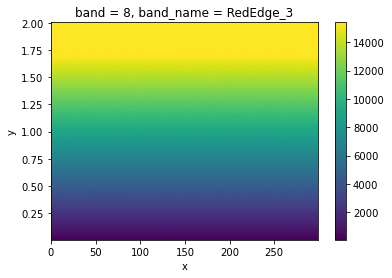

In [136]:
cmos_32 = TCMOS_test(store_steps=True,
                    TDI_rows=32,
                    lens_diameter=.25,
                    pix_per_row=8196,
                    sense_node_gain=50,
                     dark_current=570/32,
                    adc_vref=1.6)
test_output_32 = cmos_32.fit_transform(test_array)
test_output_32.isel(band=8).plot()

In [155]:
SNR = test_output_16.mean('x')/test_output_16.std('x')
SNR = SNR.swap_dims({'band':'band_name'})
median_vegetation_SNR = SNR.isel(y=100).to_pandas()
median_vegetation_SNR

band_name
Clouds            19.739396
Carotenoids       39.549952
PRI_1             24.473008
PRI_2             53.252396
Chlorophyll_1     41.433648
Chlorophyll_2     51.937264
RedEdge_1         54.464239
RedEdge_2        107.230904
RedEdge_3        103.670645
NIR              155.366257
dtype: float64

In [156]:
SNR = test_output_32.mean('x')/test_output_32.std('x')
SNR = SNR.swap_dims({'band':'band_name'})
median_vegetation_SNR = SNR.isel(y=100).to_pandas()
median_vegetation_SNR

band_name
Clouds            33.156314
Carotenoids       55.103172
PRI_1             40.451350
PRI_2             80.978241
Chlorophyll_1     62.317646
Chlorophyll_2     71.042677
RedEdge_1         78.417004
RedEdge_2        147.428715
RedEdge_3        152.274502
NIR              228.762301
dtype: float64

In [157]:
SNR = (test_output_32 + test_output_16).mean('x')/(test_output_32 + test_output_16).std('x')
SNR = SNR.swap_dims({'band':'band_name'})
median_vegetation_SNR = SNR.isel(y=100).to_pandas()
median_vegetation_SNR

band_name
Clouds            37.793219
Carotenoids       67.008234
PRI_1             45.767509
PRI_2             90.858904
Chlorophyll_1     73.912133
Chlorophyll_2     88.765002
RedEdge_1        100.649177
RedEdge_2        177.956768
RedEdge_3        187.570375
NIR              272.228797
dtype: float64

In [140]:
test_output = cmos.fit_transform(test_array)
# test_output = test_output.assign_coords(TOA_radiance=(['band','y'],
#                                                       band_radiances.isel(y=0).values))
test_output = test_output.swap_dims({'band':'band_name'})
SNR = test_output.mean('x')/test_output.std('x')


/Users/joe/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.
  """Entry point for launching an IPython kernel.


<AxesSubplot:ylabel='band_name'>

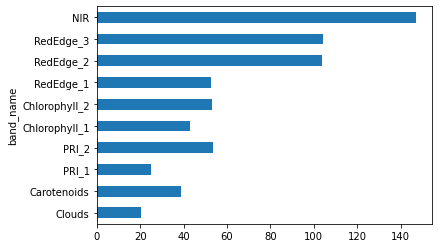

In [36]:
median_vegetation_SNR.plot('barh')

In [121]:
SNR

<xarray.DataArray (band_name: 10, y: 200)>
array([[1.08895913e+00, 1.54255637e+00, 1.98157175e+00, ...,
        4.74059458e+01, 4.82390649e+01, 4.72452677e+01],
       [1.91417752e+00, 3.39110340e+00, 4.99256283e+00, ...,
        8.28878159e+01, 8.20755817e+01, 8.11745095e+01],
       [1.21030162e+00, 1.82793278e+00, 2.58783379e+00, ...,
        5.79432910e+01, 5.32591069e+01, 5.82871015e+01],
       ...,
       [8.50249835e+00, 1.51560410e+01, 2.18189590e+01, ...,
        1.44239659e+03, 1.52493719e+03, 1.47511984e+03],
       [7.60340566e+00, 1.39665481e+01, 2.02124680e+01, ...,
        1.48161929e+03, 1.59314883e+03, 1.57008319e+03],
       [1.03759817e+01, 1.74997948e+01, 2.71245362e+01, ...,
        1.51061827e+03, 1.43763989e+03, 1.50213586e+03]])
Coordinates:
  * y          (y) float64 10.0 20.0 30.0 40.0 ... 1.98e+03 1.99e+03 2e+03
    band       (band_name) int64 0 1 2 3 4 5 6 7 8 9
  * band_name  (band_name) <U13 'Clouds' 'Carotenoids' ... 'RedEdge_3' 'NIR'

ValueError: x must be one of None, 'band', 'band_name', 'y'

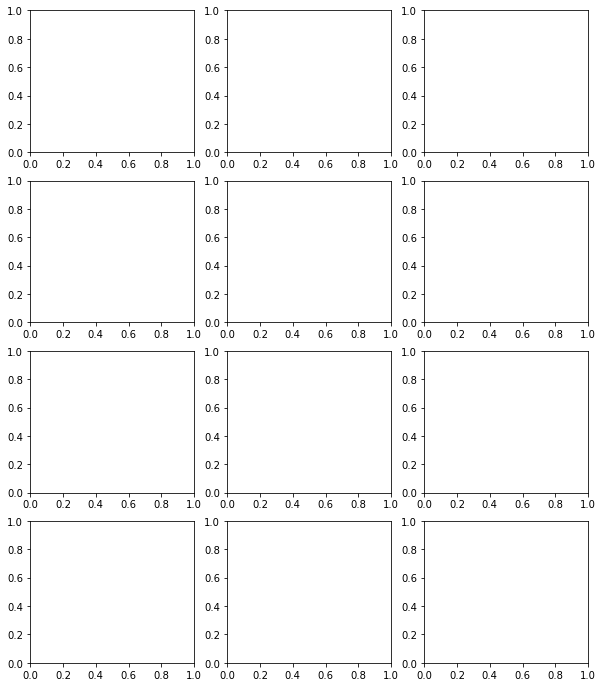

In [120]:
SNR.plot(x='TOA_radiance', col='band_name',sharex=False, sharey=False, col_wrap=3)
plt.xlabel('TOA radiance (W m-2 sr-1 micron-1)')
plt.ylabel('SNR')